# Speech Recognition

In [ ]:
pip install kapre==0.2.0

In [1]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Resizing, Rescaling, Reshape
from tensorflow.keras.utils import Sequence
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input, InputLayer, Normalization, Flatten,BatchNormalization, Dropout
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import RMSprop, SGD, Adam

from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.metrics import FalseNegatives, binary_crossentropy, binary_accuracy, categorical_crossentropy, sparse_categorical_crossentropy

from IPython.display import Audio, display

import librosa
from librosa import stft
from librosa import display as dispwav

In [2]:
np.random.seed(42)
tf.random.set_seed(42)
# Random seed

In [3]:
!nvidia-smi

Mon Sep 26 16:50:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 462.59       Driver Version: 462.59       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce MX450      WDDM  | 00000000:58:00.0 Off |                  N/A |
| N/A   55C    P8    N/A /  N/A |    119MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11204234210352896837
xla_global_id: -1
]


In [5]:
from Speech import PrepareGoogleSpeechCmd
gscInfo, nCategs = PrepareGoogleSpeechCmd(version=2, task='35word')

Google Speech commands dataset version 2 already exists. Skipping download.
Converting test set WAVs to numpy files
[]
Converting training set WAVs to numpy files
[]
Done preparing Google Speech commands dataset version 2


In [6]:
X_train, y_train = gscInfo['train']['files'], gscInfo['train']['labels']
X_test, y_test = gscInfo['test']['files'], gscInfo['test']['labels']
X_val, y_val = gscInfo['val']['files'], gscInfo['val']['labels']

In [7]:
raw_labels = {'unknown': 0,
            'silence': 0,
            '_unknown_': 0,
            '_silence_': 0,
            '_background_noise_': 0,
            'yes': 2,
            'no': 3,
            'up': 4,
            'down': 5,
            'left': 6,
            'right': 7,
            'on': 8,
            'off': 9,
            'stop': 10,
            'go': 11,
            'zero': 12,
            'one': 13,
            'two': 14,
            'three': 15,
            'four': 16,
            'five': 17,
            'six': 18,
            'seven': 19,
            'eight': 20,
            'nine': 1,
            'backward': 21,
            'bed': 22,
            'bird': 23,
            'cat': 24,
            'dog': 25,
            'follow': 26,
            'forward': 27,
            'happy': 28,
            'house': 29,
            'learn': 30,
            'marvin': 31,
            'sheila': 32,
            'tree': 33,
            'visual': 34,
            'wow': 35}
labels = dict((v,k) for k,v in raw_labels.items())

In [8]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs, labels, batch_size=32,
                 dim=16000, n_classes =36 ):
        super(DataGenerator).__init__()
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.on_epoch_end()


    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        X = np.empty((self.batch_size, self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            curX = np.load(ID)
            if curX.shape[0] == self.dim:
                X[i] = curX
            elif curX.shape[0] > self.dim:  # bigger
                randPos = np.random.randint(curX.shape[0]-self.dim)
                X[i] = curX[randPos:randPos+self.dim]
            else:  # smaller
                randPos = np.random.randint(self.dim-curX.shape[0])
                X[i, randPos:randPos + curX.shape[0]] = curX
            y[i] = self.labels[ID]

        return X,y

In [9]:
trainGen = DataGenerator(gscInfo['train']['files'], gscInfo['train']['labels'])
valGen   = DataGenerator(gscInfo['val']['files'], gscInfo['val']['labels'])
testGen  = DataGenerator(gscInfo['test']['files'], gscInfo['test']['labels'], batch_size=len(gscInfo['test']['files']))

# EDA


# Target variable analysis

c:\Users\limhu\anaconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


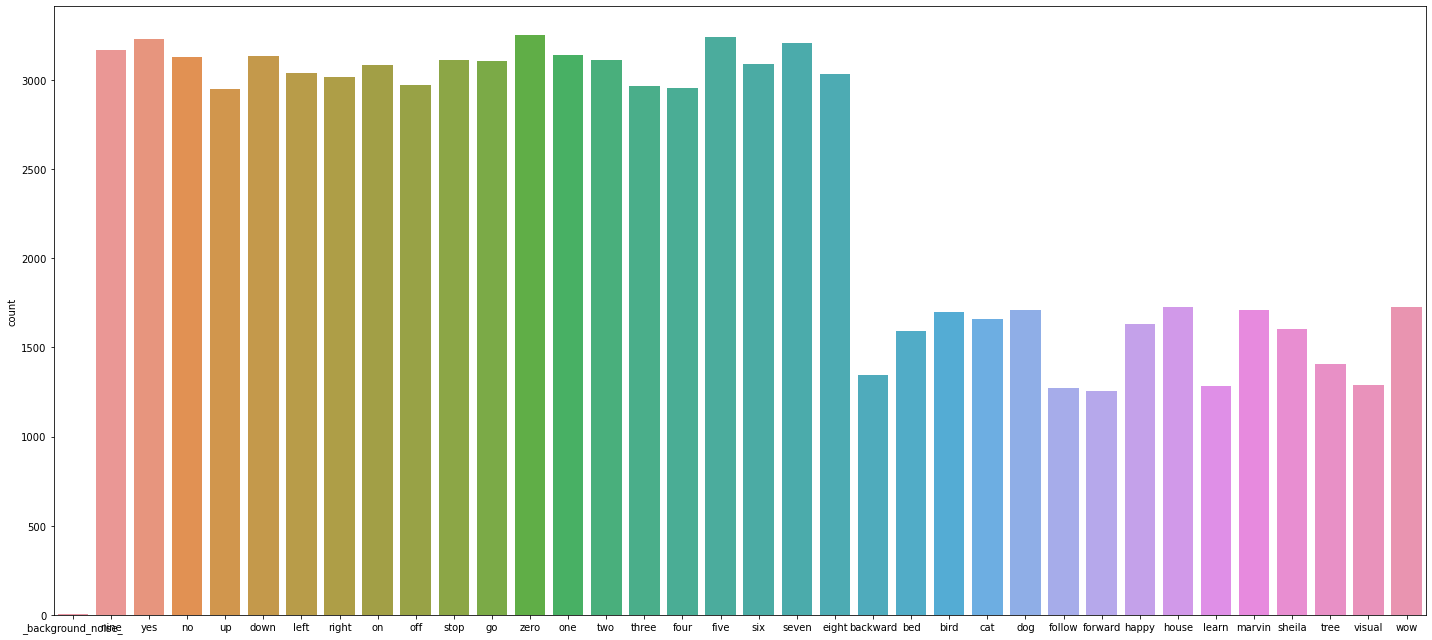

In [10]:
plt.subplots(figsize=(20,9))
sns.countplot(pd.Series(list(y_train.values())).sort_values().map(labels) )
plt.tight_layout()

In [11]:
def create_waveplot(data, sr=16000):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio', size=15)
    dispwav.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr=16000):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

In [12]:
# create_waveplot(X_train_load[randn])
# create_spectrogram(X_train_load[randn])
# display(Audio(X_train_load[randn], rate=16000))

# Preprocessing

In [13]:
# y_train, y_test, y_val = to_categorical(list(y_train.values())), to_categorical(list(y_test.values())), to_categorical(list(y_val.values()))

# Modelling


In [33]:
MAX_EPOCHS = 10

In [15]:
def baseline(IL = 16000, categories = nCategs):
    inputs = Input((IL,))
    x = Normalization()(inputs)
    x = Reshape((1,-1))(inputs)
    x = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, 16000),
                       padding='same', sr=16000, n_mels=80,
                       fmin=40.0, fmax=16000 / 2, power_melgram=1.0,
                       return_decibel_melgram=True, trainable_fb=False,
                       trainable_kernel=False,
                       name='mel_stft')(x)
    x = Dense(64, activation = 'leaky_relu')(x)
    outputs = Dense(categories, activation = 'softmax')(x)
    model = Model(inputs = [inputs], outputs= [outputs])
    return model
iters = len(X_train)/128
LR = tf.keras.optimizers.schedules.CosineDecayRestarts(
    0.001,
    iters * 10 
)

# model = baseline()


# BASELINE CNN MODEL

In [35]:
def baseline():
    input_shape=(16000,)
    CNNmodel = Sequential(

    )
    CNNmodel.add(Input(input_shape))
    CNNmodel.add(Reshape((1,-1)))
    CNNmodel.add(Melspectrogram(input_shape = (1, 16000),trainable = False))
    CNNmodel.add(Conv2D(32, (3, 3), activation='relu'))
    CNNmodel.add(MaxPooling2D((2, 2)))
    CNNmodel.add(Dropout(0.2))
    CNNmodel.add(Conv2D(64, (3, 3), activation='relu'))
    CNNmodel.add(MaxPooling2D((2, 2)))
    CNNmodel.add(Dropout(0.2))
    CNNmodel.add(Conv2D(64, (3, 3), activation='relu'))
    CNNmodel.add(Flatten())
    CNNmodel.add(Dense(64, activation='relu'))
    CNNmodel.add(Dropout(0.2))
    CNNmodel.add(Dense(32, activation='relu'))
    CNNmodel.add(Dense(36, activation='softmax'))
    return CNNmodel
model = baseline()
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)
# model.fit()
results = model.fit(trainGen, validation_data=valGen, epochs=MAX_EPOCHS, callbacks=[EarlyStopping(monitor='val_accuracy', verbose=1, patience=10)])

Epoch 1/10
2651/2651 [==============================] - 1424s 537ms/step - loss: 1.7407 - accuracy: 0.4949 - val_loss: 0.8563 - val_accuracy: 0.7518
Epoch 2/10
2651/2651 [==============================] - 1526s 576ms/step - loss: 0.9639 - accuracy: 0.7103 - val_loss: 0.6121 - val_accuracy: 0.8179
Epoch 3/10
2651/2651 [==============================] - 2437s 919ms/step - loss: 0.7674 - accuracy: 0.7675 - val_loss: 0.5660 - val_accuracy: 0.8356
Epoch 4/10
2651/2651 [==============================] - 2003s 756ms/step - loss: 0.6625 - accuracy: 0.7986 - val_loss: 0.5599 - val_accuracy: 0.8314
Epoch 5/10
2651/2651 [==============================] - 1376s 519ms/step - loss: 0.5925 - accuracy: 0.8185 - val_loss: 0.4912 - val_accuracy: 0.8579
Epoch 6/10
2651/2651 [==============================] - 2118s 799ms/step - loss: 0.5314 - accuracy: 0.8370 - val_loss: 0.4875 - val_accuracy: 0.8573
Epoch 7/10
2651/2651 [==============================] - 1916s 723ms/step - loss: 0.4932 - accuracy: 0.8473

Loss/accuracy plot

In [45]:
import plotly.graph_objects as go
def plot_loss_curve(model_history):
  model_history = pd.DataFrame(model_history)
  epochs = list(range(1, len(model_history) + 1))
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=epochs, y=model_history["loss"],
                    mode='lines+markers',
                    name='Training Loss'))
  fig.add_trace(go.Scatter(x=epochs, y=model_history["val_loss"],
                    mode='lines+markers',
                    name='Validation Loss'))
  fig.add_trace(go.Scatter(x=epochs, y=model_history["accuracy"],
                    mode="lines+markers",
                    name="Training Accuracy"))
  fig.add_trace(go.Scatter(x=epochs, y=model_history["val_accuracy"],
                           mode="lines+markers",
                           name="Validation Accuracy"))
  fig.update_layout(
    title="Loss/Acc Plot",
    xaxis_title="Epochs",
    yaxis_title="Loss/Acc",
)

  return fig
fig = plot_loss_curve(results.history)
fig.show()

In [26]:
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import *

In [34]:
class Split(Layer):
    def __init__(self, width, **kwargs):
        super(Split, self).__init__(**kwargs)
        self.width = width

    def call(self, inputs):
        # print(inputs.get_shape().as_list())
        data = tf.split(inputs, self.width, 1)
        # print(data.get_shape().as_list())
        data = tf.stack(data, axis=1)
        # print(data.get_shape().as_list())
        return data

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.width, input_shape[1] // self.width, *input_shape[2:])

    def get_config(self):
        config = {'width': self.width}
        base_config = super(Split, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
m = input = Input((16000, 1))

m = Conv1D(64,
           input_shape=(16000, 1),
           kernel_size=100,
           strides=4,
           padding='same',
           kernel_initializer='he_normal',
           kernel_regularizer=l2(l=0.0001))(m)
m = BatchNormalization()(m)
m = Activation('relu')(m)
m = MaxPooling1D(pool_size=4, strides=None)(m)

for i in range(4):
    m = Conv1D(2 ** 6,
               kernel_size=3,
               strides=1,
               padding='same',
               kernel_initializer='glorot_uniform',
               kernel_regularizer=l2(l=0.0001))(m)
    m = BatchNormalization()(m)
    m = Activation('relu')(m)
m = MaxPooling1D(pool_size=4, strides=None)(m)
m = Reshape((250, 64, 1))(m)

m = Split(25)(m)
for i in range(3):
    m = ConvLSTM2D(2 ** (i + 3), (3, 3), padding='same', return_sequences=True)(m)
    m = BatchNormalization()(m)

# -------- Pooling in time --------------
m = TimeDistributed(GlobalAveragePooling2D())(m)

# --------- Thinking --------------------
m = LSTM(512, return_sequences=True)(m)
m = BatchNormalization()(m)
m = LSTM(512, return_sequences=True)(m)
m = BatchNormalization()(m)

# ---------- Result ---------------------
m = LSTM(36)(m)
m = Activation('softmax')(m)

model = Model(inputs=input, outputs=m)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 16000, 1)]        0         
                                                                 
 conv1d_31 (Conv1D)          (None, 4000, 64)          6464      
                                                                 
 batch_normalization_43 (Bat  (None, 4000, 64)         256       
 chNormalization)                                                
                                                                 
 activation_32 (Activation)  (None, 4000, 64)          0         
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 1000, 64)         0         
 g1D)                                                            
                                                                 
 conv1d_32 (Conv1D)          (None, 1000, 64)          1235

In [19]:
# results = model.fit(trainGen, validation_data=valGen, epochs=2, callbacks=[EarlyStopping(monitor='categorical_accuracy', verbose=1, patience=10)])

# RNN

In [19]:
from tensorflow.keras.layers import *

In [21]:
def BasicLSTM(nCategories=36, InputLength=None):

    inputs = Input((InputLength,), name='input')

    x = Reshape((1, -1))(inputs)

    m = Melspectrogram(input_shape=(1, InputLength), trainable=False)(x)

    x = Normalization2D(int_axis=0, name='mel_stft_norm')(m)

    x = Permute((2, 1, 3))(x)

    x = Conv2D(10, (5, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1, (5, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)

    x = Bidirectional(LSTM(64, return_sequences=True))(x)  # [b_s, seq_len, vec_dim]
    x = Bidirectional(LSTM(64, return_sequences=True))(x)  # [b_s, seq_len, vec_dim]

    xFirst = Lambda(lambda q: q[:, -1])(x)  
    query = Dense(128)(xFirst)
    # vector to identify what part of the audio is the most relevant

    # dot product attention layer
    attScores = Dot(axes=[1, 2])([query, x])
    attScores = Softmax(name='attSoftmax')(attScores)  # attention scores and weights

    # rescale sequence
    attVector = Dot(axes=[1, 1])([attScores, x])  

    x = Dense(64, activation='relu')(attVector)
    x = Dense(32)(x)

    output = Dense(nCategories, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs], outputs=[output])

    return model

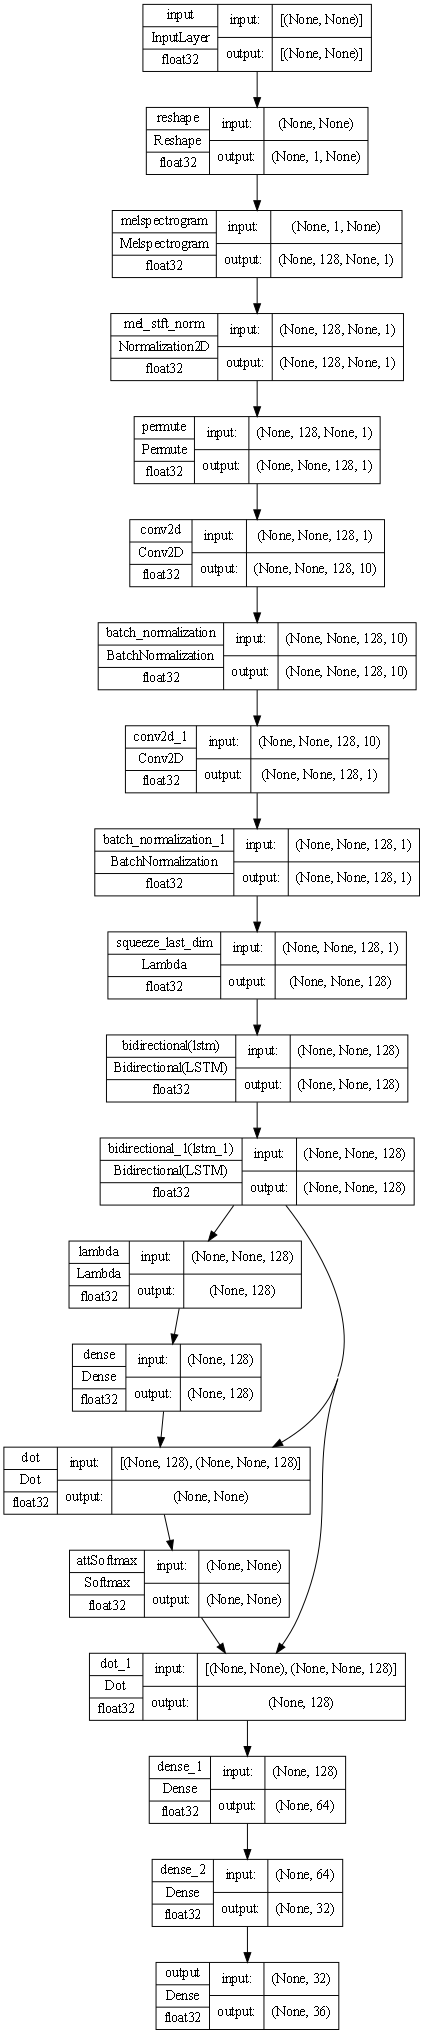

In [22]:
# Credits: https://arxiv.org/pdf/1808.08929.pdf
rnn = BasicLSTM()
from tensorflow.keras.utils import plot_model
plot_model(rnn, show_shapes=True, show_dtype=True,
    show_layer_names=True, expand_nested=True, dpi=70)

In [26]:
rnn.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])

In [28]:
results = rnn.fit(trainGen, validation_data=valGen, epochs=MAX_EPOCHS, callbacks=[EarlyStopping(monitor='sparse_categorical_accuracy', verbose=1, patience=10)])

Epoch 1/20
  21/2651 [..............................] - ETA: 32:44 - loss: 3.4799 - sparse_categorical_accuracy: 0.0744

KeyboardInterrupt: 

In [104]:
loadmod = tf.keras.models.load_model('RNN/soundlstm/' )

In [8]:
np.unique(list(gscInfo['train']['labels'].values()), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]),
 array([   6, 3170, 3228, 3130, 2948, 3134, 3037, 3019, 3086, 2970, 3111,
        3106, 3250, 3140, 3111, 2966, 2955, 3240, 3088, 3205, 3033, 1346,
        1594, 1697, 1657, 1711, 1275, 1256, 1632, 1727, 1286, 1710, 1606,
        1407, 1288, 1724], dtype=int64))

# Data Augmentation

In [22]:
# def add_noise(data, factor=0.03):
#     noise_amp = factor*np.random.uniform()*np.amax(data)
#     data = data + noise_amp*np.random.normal(size=data.shape[0])
#     return data

In [23]:
# def stretch(data, rate=0.8):
#     return librosa.effects.time_stretch(data, rate)